### ELV Assignment 1
[Reference Paper](https://www.pnas.org/doi/10.1073/pnas.1802705116)  
[Reference video 1](https://youtu.be/9GkxEEqEGhg?si=eSbcXl5bgqmUorJJ)  
[Reference video 2](https://www.youtube.com/watch?v=hEGGa8y5_wM)  
[pythonspeed](https://pythonspeed.com/)


![Fig 2 from paper](./figures/fig2.png)


* Hard Phases
* What is Information theoretically possible
* Write about GAMP
* LR does'nt have prior info about the fact that the weights are binary unlike the AMP algorithm

#### PROBLEMS:
* Interpreting different random seed's effect
* Why is there not a direct correspondance with the plot from the paper
* is regularisation good enough
* effect of increasing D
* should we try for larger alpha range (to see if there's any phase transition)
* consider implementing more optimisations
* LR might struggle with high D, why and how to fix

### problems to fix:  
* kernel crashes at large D
* the plots dont match (at D=10^4)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import gc

def run_experiment(D=10000, teacher_seed=42):
    # Step 1: Generate teacher model (with random binary weights)
    # we do some things to be able to generate data for large D without memory issues
    np.random.seed(teacher_seed) 
    w_teacher = np.random.choice([1, -1], size=D) # arr of size D with +-1 

    # Step 2: Generate dataset
    N_total = int(2.2 * D)  # 2D (train) + 0.2D (test)
    print('wgenerated')
    X = np.random.randn(N_total, D)  
    print(X.shape,w_teacher.shape)
    y = np.sign(X@(w_teacher))  # labels {+1,-1} 
    y[y == 0] = 1  # Replace any 0s with 1
    del w_teacher
    gc.collect()
    print('X,y computed')
    # comment out 
    X = np.memmap('./X_data.dat', dtype='float16', mode='r', shape=(N_total, D))
    y = np.memmap('./y_data.dat', dtype='float16', mode='r', shape=(N_total,))
    # Split dataset into test and train
    X_train, X_test = X[:2*D], X[2*D:]
    y_train, y_test = y[:2*D], y[2*D:]
    del X, y
    gc.collect() 
    # Define range of α values
    print("success, test train split done")
    alphas = np.arange(0.2, 2.2, 0.2) # [0.2,0.4...2]
    test_errors = []

    # Precompute hyperparameter grid for Logistic Regression
    Cs = np.logspace(-4, 6, 15) 

    for alpha in alphas:
        n = int(alpha * D)
        X_subset = X_train.view()[:n] # prevent array copying
        y_subset = y_train.view()[:n]

        # Train Logistic Regression with cross-validation
        model = LogisticRegressionCV(
            Cs=Cs, cv=4, penalty='l2', solver='saga',
            max_iter=100000, tol=1e-3, random_state=teacher_seed, n_jobs=-1
        )
        model.fit(X_subset, y_subset)
        y_pred = model.predict(X_test)

        # Compute classification error (misclassification rate)
        test_error = np.mean(np.square(y_test-y_pred)) 
        test_errors.append(test_error)

        print(f"Alpha={alpha:.1f}, Error={test_error:.4f}")

    return alphas, test_errors

def plot_results(alphas, errors_list, labels, D,name):
    plt.figure(figsize=(10, 6))
    for errors, label in zip(errors_list, labels):
        plt.plot(alphas, errors, 'o-', label=label)
    plt.xlabel('Sample Complexity (α)')
    plt.ylabel('Test Error')
    plt.title(f'Generalization Error vs α (D={D})')
    plt.grid(True)
    plt.ylim(0,)
    plt.legend()

    # Save figure 
    filename = f'./figures/generalization_error_D{D}_{name}.png'
    plt.savefig(filename)
    plt.show()

    print(f"Plot saved as {filename}")

# Experiment: Run with different teacher seeds
# This will fail for large D (especially due to memory issues) -> fix using batches, torch blah blah
D = int(1e4) # dimensionality   
teacher_seed1,teacher_seed2 = 42,2004

#alphas, errors1 = run_experiment(D=D, teacher_seed=teacher_seed1)
#_, errors2 = run_experiment(D=D, teacher_seed=teacher_seed2)
#plot_results(alphas, [errors1, errors2], [f'Teacher 1, seed = {teacher_seed1}', f'Teacher 2, seed = {teacher_seed2}'], D=D,name='combined')
#plot_results(alphas, [errors1], [f'seed = {teacher_seed1}'], D=D,name = 'teacher 1')
#plot_results(alphas, [errors2], [f'seed = {teacher_seed2}'], D=D,name = 'teacher 2')

In [2]:
import jax
import seaborn as sns
import jax.numpy as jnp
from jax import jit, random
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import psutil
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

# Log resource usage
def log_resource_usage():
    memory = psutil.virtual_memory()
    print(f"Memory Usage: {memory.percent}% | Available: {memory.available / (1024**3):.2f} GB")

# Calculate batch size
def calculate_optimal_batch_size(D):
    available_memory_gb = psutil.virtual_memory().available / (1024**3)
    max_memory_usage_gb = available_memory_gb * 0.6  # Use 60% of available memory
    estimated_batch_size_gb = D * 2 / (1024**3)  # Assuming float16 (2 bytes per value)
    optimal_batch_size = int(max_memory_usage_gb / estimated_batch_size_gb * 1e4)
    return max(1000, min(optimal_batch_size, int(1e4)))

def calculate_cross_entropy_loss(y_true, y_prob):
    """
    Manually compute cross-entropy loss
    y_true: binary labels (0 or 1)
    y_prob: predicted probabilities of positive class
    """
    # Avoid numerical instability
    epsilon = 1e-15
    y_prob = np.clip(y_prob, epsilon, 1 - epsilon)

    # Binary cross-entropy calculation
    loss = -(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))

    # Detailed breakdown
    #print("\nManual CE Loss Breakdown:")
    #print("Unique true labels:", np.unique(y_true))
    #print("Probability range:", y_prob.min(), y_prob.max())

    # Compute individual losses
    pos_mask = y_true == 1
    neg_mask = y_true == 0

    #print("Positive class losses:")
    #print("  Mean:", loss[pos_mask].mean())
    #print("  Min:", loss[pos_mask].min())
    #print("  Max:", loss[pos_mask].max())

    #print("Negative class losses:")
    #print("  Mean:", loss[neg_mask].mean())
    #print("  Min:", loss[neg_mask].min())
    #print("  Max:", loss[neg_mask].max())

    return loss.mean()
# Generate Data
def generate_data(D=10000, teacher_seed=42, alpha_min=0.2, alpha_max=2):
    try:
        print("Initializing data generation...")
        key = random.PRNGKey(teacher_seed)
        w_teacher = 2 * random.bernoulli(key, 0.5, shape=(D,)) - 1

        N_total = int((alpha_max + alpha_min) * D)
        print('Creating memory-mapped data...')
        X = np.memmap('./X_data.dat', dtype='float16', mode='w+', shape=(N_total, D))
        y = np.memmap('./y_data.dat', dtype='float16', mode='w+', shape=(N_total,))

        batch_size = calculate_optimal_batch_size(D)
        num_batches = (N_total + batch_size - 1) // batch_size
        key = random.split(key, num_batches)

        @jit
        def process_batch(subkey, w_teacher):
            X_batch = (random.normal(subkey, (batch_size, D))).astype(jnp.float16)
            y_batch = jnp.sign(X_batch @ w_teacher).astype(jnp.float16)
            y_batch = jnp.where(y_batch == 0, 1, y_batch)
            return X_batch, y_batch

        for i in range(num_batches):
            start = i * batch_size
            end = min((i + 1) * batch_size, N_total)
            current_batch_size = end - start
            print(f"Processing batch {start}-{end}")
            log_resource_usage()
            X_batch, y_batch = process_batch(key[i], w_teacher)
            X[start:end] = np.asarray(X_batch[:current_batch_size])
            y[start:end] = np.asarray(y_batch[:current_batch_size])

        del w_teacher, key, X_batch, y_batch
        gc.collect()
        print("Data generation completed.")

    except MemoryError:
        print("MemoryError: Reduce D or batch size.")
        exit()

# Run Logistic Regression Experiment

def run_experiment2(D=10000, teacher_seed=42, alpha_max=2, alpha_min=0.2, alpha_step=0.2):
    try:
        N_total = int((alpha_max + alpha_min) * D)
        X = np.memmap('./X_data.dat', dtype='float16', mode='r', shape=(N_total, D))
        y = np.memmap('./y_data.dat', dtype='float16', mode='r', shape=(N_total,))

        X_train = X[:int(alpha_max * D)]
        X_test = X[int(alpha_max * D):]
        y_train = y[:int(alpha_max * D)]
        y_test = y[int(alpha_max * D):]

        alphas = np.arange(alpha_min, alpha_max + alpha_step, alpha_step)
        test_errors = []

        Cs = np.logspace(np.log10(D)-1,np.log10(D)+1,10)
        for alpha in alphas:
            n = int(alpha * D)
            X_subset = X_train[:n]# * jnp.sqrt(1/D) # making variance 1/D
            y_subset = y_train[:n]

            # Print subset information

            model = LogisticRegressionCV(
                Cs=Cs/alpha,
                cv=3,
                penalty='l2',
                solver='saga',
                max_iter=int(1e5),
                tol=1e-8,
                random_state=teacher_seed,
            )

            model.fit(X_subset, y_subset)

            # Detailed model diagnostics
            print("Norm Square of coefficients:", (np.linalg.norm(model.coef_))**2)
            print("Coefficient min/max:", model.coef_.min(), model.coef_.max())

            y_pred = model.predict(X_test)
            prob_pred = model.predict_proba(X_test)

            # Detailed prediction analysis
            print("Min probability:", prob_pred.min())
            print("Max probability:", prob_pred.max())
            print("Mean probability of positive class:", prob_pred[:, 1].mean())

            z = model.decision_function(X_test)
            print("Decision function z: ")
            print(f"Min z: {np.min(z)}")
            print(f"Max z: {np.max(z)}")
            print(f"Mean z: {np.mean(z)}")
            print(f"Standard Deviation of z: {np.std(z)}")


            test_error = np.mean(np.square(y_test - y_pred))
            test_errors.append(float(test_error))

            # More detailed loss calculation
            y_binary = (y_test + 1) // 2
            w = model.coef_.flatten()
            regularization_term = (1/(2*model.C_[0]))*np.linalg.norm(w)**2
            y_binary = (y_test + 1) // 2
            y_prob = model.predict_proba(X_test)[:, 1]

            cross_entropy_loss = calculate_cross_entropy_loss(y_binary,y_prob)
            total_loss = regularization_term + cross_entropy_loss

            print(f"Alpha: {alpha:3g} | Optimal C: {model.C_[0]:4g} | Error: {test_error:3g}")
            print(f"(1/2C)||w||^2 (Regularization Term): {regularization_term:.6g} | CE term: {cross_entropy_loss:6g}")
            print(f"Regularization Contribution (%): {100 * regularization_term / total_loss:.2f}%")
            print()
            sns.histplot(prob_pred[:, 1][y_test == 1], color='blue', label='Positive Class', stat='count',alpha=0.5)
            sns.histplot(prob_pred[:, 1][y_test == -1], color='red', label='Negative Class', stat='count',alpha=0.5)
            plt.title('Probability Distribution for Positive and Negative Classes')
            plt.xlabel('Predicted Probability')
            plt.ylabel('Counts')
            plt.legend()
            plt.show()

            del y_binary,w,y_prob
            gc.collect()

        return alphas, test_errors

    except Exception as e:
        print(f"Error in experiment: {e}")
        import traceback
        traceback.print_exc()
        return [], []

def print_file_info(file_path):
    if os.path.isfile(file_path):
        file_size_bytes = os.path.getsize(file_path)
        file_size_gb = file_size_bytes / (1024 ** 3)
        print(f"File: {file_path}")
        print(f"Size: ({file_size_gb:.4f} GB)")
    else:
        print(f"File not found: {file_path}")

# Plot Results
def plot_results(alphas, errors_list, labels, D, name):
    plt.figure(figsize=(10, 6))
    for errors, label in zip(errors_list, labels):
        plt.plot(alphas, errors, 'o-', label=label)
    plt.xlabel('Sample Complexity (α)')
    plt.ylabel('Generalization Error (MSE)')
    plt.title(f'Generalization Error vs α (D={D})')
    plt.grid(True)
    plt.ylim(0, )
    plt.legend()

    os.makedirs('./figures', exist_ok=True)
    filename = f'./figures/generalization_error_D{D}_{name}.png'
    plt.savefig(filename)

    plt.show()
    print(f"Plot saved as {filename}")

In [3]:
import numpy as np
import gc
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold

def calculate_cross_entropy_loss_batched(y_true, y_pred, batch_size=1024):
    """
    Compute cross-entropy loss in batches to prevent memory issues.
    """
    epsilon = 1e-15 # To prevent log(0)
    total_loss = 0.0
    total_samples = len(y_true)
    
    for i in range(0, total_samples, batch_size):
        batch_end = min(i + batch_size, total_samples)
        batch_true = y_true[i:batch_end]
        batch_pred = y_pred[i:batch_end]

        batch_pred = np.clip(batch_pred, epsilon, 1 - epsilon)
        batch_loss = -(batch_true * np.log(batch_pred) + (1 - batch_true) * np.log(1 - batch_pred))
        total_loss += np.sum(batch_loss)
    
    return total_loss / total_samples if total_samples > 0 else float('inf')

def batch_predict_proba(model, X, batch_size=1024):
    """
    Perform batched probability prediction to handle large datasets correctly.
    """
    total_samples = len(X)
    probas = np.zeros(total_samples)  # Preallocate array for efficiency

    for i in range(0, total_samples, batch_size):
        batch_end = min(i + batch_size, total_samples)
        batch = X[i:batch_end]
        print(f"Processing batch {i}-{batch_end}")
        probas[i:batch_end] = model.predict_proba(batch)[:, 1]
        print("probas",probas)
    return probas


def batch_predict(model, X, batch_size):
    """
    Perform batched prediction to handle large datasets efficiently.
    """
    total_samples = len(X)
    predictions = np.zeros(total_samples, dtype=int)  # Preallocate for efficiency

    for i in range(0, total_samples, batch_size):
        batch_end = min(i + batch_size, total_samples)
        batch = X[i:batch_end]
        predictions[i:batch_end] = model.predict(batch)  # Directly predict {-1,1}

    return predictions

def optimized_training(D, teacher_seed, alpha_max=2, alpha_min=0.2, alpha_step=0.2, 
                        n_splits=4, batch_size=4096, num_epochs=5):
    """Train an SGD classifier using cross-validation with memory-efficient data handling."""
    
    N_total = int((alpha_max + alpha_min) * D)
    X = np.memmap('./X_data.dat', dtype='float16', mode='r', shape=(N_total, D))
    y = np.memmap('./y_data.dat', dtype='float16', mode='r', shape=(N_total,))
    
    train_size = int(alpha_max * D)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    alphas = np.arange(alpha_min, alpha_max+alpha_step, alpha_step) 
    test_errors = []
    reg_values = np.logspace(-4, 2, 15)  # Adjusted regularization range
    
    kf = KFold(n_splits=n_splits, shuffle=False)  # **No shuffling**
    
    for alpha in alphas:
        n_samples = int(alpha * D)
        X_subset, y_subset = X_train[:n_samples], y_train[:n_samples]
        
        best_model = None
        best_loss = float('inf')
        best_alpha_value = None
        
        print(f"Alpha = {alpha}")
        
        for reg_alpha in reg_values:
            print(f"  Regularization alpha = {reg_alpha}")
            avg_loss = 0
            
            model = SGDClassifier(
                loss='log_loss',
                penalty='l2',
                alpha=reg_alpha,
                max_iter=1,  # **1 iteration per partial_fit call**
                tol=None,  
                random_state=teacher_seed,
                warm_start=True,
                n_jobs=-1,
                learning_rate='optimal'
            )
            
            print("  Training model...")
            
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_subset), start=1):
                print(f"    Fold {fold_idx}/{n_splits}")

                for epoch in range(num_epochs):
                    for batch_start in range(0, len(train_idx), batch_size):
                        batch_end = min(batch_start + batch_size, len(train_idx))
                        batch_train_idx = train_idx[batch_start:batch_end]
                        
                        if len(batch_train_idx) > 0:
                            model.partial_fit(
                                X_subset[batch_train_idx],
                                y_subset[batch_train_idx],
                                classes=[-1, 1]
                            )

                print("Computing probabilities of each binary class")
                try:
                    prob_pred = batch_predict_proba(model, X_subset[val_idx], batch_size=batch_size)
                    val_labels_binary = (y_subset[val_idx] + 1) // 2
                    print("      Computing validation loss...")
                    loss = calculate_cross_entropy_loss_batched(val_labels_binary, prob_pred, batch_size=batch_size)
                    avg_loss += loss / n_splits
                except Exception as e:
                    print(f"      Error in validation: {e}")
                    avg_loss = float('inf')
                    break
            
            if avg_loss < best_loss:
                best_loss = avg_loss
                best_alpha_value = reg_alpha
                best_model = model
        
        print("  Evaluating on test set...")
        try:
            y_test_pred = batch_predict(best_model, X_test, batch_size=batch_size)  
            test_error = np.mean((y_test - y_test_pred) ** 2)  # Compute MSE  
            test_errors.append(test_error)
            print()
            print(f"  Alpha: {alpha:.3g} | Best regularization alpha: {best_alpha_value:.4g} | Test Error: {test_error:.3g}")
            print()
        except Exception as e:
            print(f"  Error in test set evaluation: {e}")
            test_errors.append(float('inf'))
        
        del model, best_model
        gc.collect()
    
    return alphas, test_errors


In [4]:
import numpy as np
import gc
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
from tqdm import tqdm

def calculate_cross_entropy_loss_batched(y_true, y_pred, batch_size=1024):
    epsilon = 1e-15
    total_loss = 0.0
    total_samples = len(y_true)
    
    for i in range(0, total_samples, batch_size):
        batch_end = min(i + batch_size, total_samples)
        batch_true = y_true[i:batch_end]
        batch_pred = y_pred[i:batch_end]
        
        batch_pred = np.clip(batch_pred, epsilon, 1 - epsilon)
        batch_loss = -(batch_true * np.log(batch_pred) + (1 - batch_true) * np.log(1 - batch_pred))
        total_loss += np.sum(batch_loss)
    
    return total_loss / total_samples if total_samples > 0 else float('inf')

def batch_predict_proba(model, X, batch_size=1024):
    total_samples = len(X)
    probas = np.zeros(total_samples)
    
    for i in range(0, total_samples, batch_size):
        batch_end = min(i + batch_size, total_samples)
        batch = X[i:batch_end]
        probas[i:batch_end] = model.predict_proba(batch)[:, 1]
    return probas

def batch_predict(model, X, batch_size):
    total_samples = len(X)
    predictions = np.zeros(total_samples, dtype=int)
    
    for i in range(0, total_samples, batch_size):
        batch_end = min(i + batch_size, total_samples)
        batch = X[i:batch_end]
        predictions[i:batch_end] = model.predict(batch)
    
    return predictions

def train_model_for_alpha(alpha, D, teacher_seed, X_train, y_train, X_test, y_test, kf, reg_values, batch_size, num_epochs, n_splits):
    n_samples = int(alpha * D)
    X_subset, y_subset = X_train[:n_samples], y_train[:n_samples]
    
    best_model = None
    best_loss = float('inf')
    best_alpha_value = None
    
    for reg_alpha in tqdm(reg_values, desc=f"Alpha {alpha:.3g}"):
        avg_loss = 0
        model = SGDClassifier(
            loss='log_loss',
            penalty='l2',
            alpha=reg_alpha,
            max_iter=1,
            tol=None,
            random_state=teacher_seed,
            warm_start=True,
            n_jobs=-1,
            learning_rate='optimal'
        )
        
        for train_idx, val_idx in kf.split(X_subset):
            for epoch in range(num_epochs):
                for batch_start in range(0, len(train_idx), batch_size):
                    batch_end = min(batch_start + batch_size, len(train_idx))
                    batch_train_idx = train_idx[batch_start:batch_end]
                    
                    if len(batch_train_idx) > 0:
                        model.partial_fit(
                            X_subset[batch_train_idx],
                            y_subset[batch_train_idx],
                            classes=[-1, 1]
                        )
            
            prob_pred = batch_predict_proba(model, X_subset[val_idx], batch_size=batch_size)
            val_labels_binary = (y_subset[val_idx] + 1) // 2
            loss = calculate_cross_entropy_loss_batched(val_labels_binary, prob_pred, batch_size=batch_size)
            avg_loss += loss / n_splits
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_alpha_value = reg_alpha
            best_model = model
    
    y_test_pred = batch_predict(best_model, X_test, batch_size=batch_size)
    test_error = np.mean((y_test - y_test_pred) ** 2)
    
    return alpha, best_alpha_value, test_error

def optimized_training(D, teacher_seed, alpha_max=2, alpha_min=0.2, alpha_step=0.2, 
                        n_splits=3, batch_size=4096, num_epochs=5, n_jobs=-1):
    N_total = int((alpha_max + alpha_min) * D)
    X = np.memmap('./X_data.dat', dtype='float16', mode='r', shape=(N_total, D))
    y = np.memmap('./y_data.dat', dtype='float16', mode='r', shape=(N_total,))
    
    train_size = int(alpha_max * D)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    alphas = np.arange(alpha_min, alpha_max + alpha_step, alpha_step)
    reg_values = np.logspace(-2.5, 0, 20)
    kf = KFold(n_splits=n_splits, shuffle=False)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(train_model_for_alpha)(alpha, D, teacher_seed, X_train, y_train, X_test, y_test, kf, reg_values, batch_size, num_epochs, n_splits)
        for alpha in tqdm(alphas, desc="Training Progress")
    )
    
    alphas, best_reg_values, test_errors = zip(*results)
    
    for alpha, best_reg, error in results:
        print(f"Alpha: {alpha:.3g} | Best regularization alpha: {best_reg:.4g} | Test Error: {error:.3g}")
    
    return alphas, test_errors


In [ ]:
D = int(1e5)
alpha_min,alpha_max,alpha_step = 0.2,2,0.2
teacher_seed1, teacher_seed2 = 24,72

two_teachers = (D<=1e4) # change this lol 

generate_data(D=D, teacher_seed=teacher_seed1,alpha_max=alpha_max,alpha_min=alpha_min)

Initializing data generation...
Creating memory-mapped data...
Processing batch 0-10000
Memory Usage: 67.2% | Available: 5.26 GB
Processing batch 10000-20000
Memory Usage: 36.9% | Available: 10.09 GB
Processing batch 20000-30000
Memory Usage: 41.0% | Available: 9.44 GB
Processing batch 30000-40000
Memory Usage: 42.4% | Available: 9.21 GB
Processing batch 40000-50000
Memory Usage: 44.4% | Available: 8.90 GB
Processing batch 50000-60000
Memory Usage: 37.9% | Available: 9.93 GB
Processing batch 60000-70000
Memory Usage: 44.7% | Available: 8.85 GB
Processing batch 70000-80000
Memory Usage: 38.1% | Available: 9.91 GB
Processing batch 80000-90000
Memory Usage: 38.4% | Available: 9.85 GB
Processing batch 90000-100000
Memory Usage: 47.7% | Available: 8.36 GB
Processing batch 100000-110000
Memory Usage: 45.2% | Available: 8.78 GB
Processing batch 110000-120000
Memory Usage: 42.1% | Available: 9.26 GB
Processing batch 120000-130000
Memory Usage: 38.9% | Available: 9.78 GB
Processing batch 130000

File: ./X_data.dat
Size: (0.4098 GB)
File: ./y_data.dat
Size: (0.0000 GB)


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Users/loki/Internship/anaconda3/envs/pyoperon/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
Alpha 2: 100%|██████████| 20/20 [03:54<00:00, 11.74s/it]


Alpha: 0.2 | Best regularization alpha: 0.2198 | Test Error: 1.63
Alpha: 0.4 | Best regularization alpha: 0.1199 | Test Error: 1.42
Alpha: 0.6 | Best regularization alpha: 0.1624 | Test Error: 1.35
Alpha: 0.8 | Best regularization alpha: 0.08859 | Test Error: 1.12
Alpha: 1 | Best regularization alpha: 0.08859 | Test Error: 1.01
Alpha: 1.2 | Best regularization alpha: 0.08859 | Test Error: 0.916
Alpha: 1.4 | Best regularization alpha: 0.06543 | Test Error: 0.864
Alpha: 1.6 | Best regularization alpha: 0.04833 | Test Error: 0.818
Alpha: 1.8 | Best regularization alpha: 0.0357 | Test Error: 0.772
Alpha: 2 | Best regularization alpha: 0.0357 | Test Error: 0.748
Initializing data generation...
Creating memory-mapped data...
Processing batch 0-10000
Memory Usage: 71.4% | Available: 4.57 GB
Processing batch 10000-20000
Memory Usage: 66.6% | Available: 5.34 GB
Processing batch 20000-22000
Memory Usage: 66.8% | Available: 5.32 GB
Data generation completed.


Alpha 2: 100%|██████████| 20/20 [04:01<00:00, 12.07s/it]


Alpha: 0.2 | Best regularization alpha: 0.2976 | Test Error: 1.63
Alpha: 0.4 | Best regularization alpha: 0.1199 | Test Error: 1.38
Alpha: 0.6 | Best regularization alpha: 0.08859 | Test Error: 1.27
Alpha: 0.8 | Best regularization alpha: 0.08859 | Test Error: 1.15
Alpha: 1 | Best regularization alpha: 0.08859 | Test Error: 1.03
Alpha: 1.2 | Best regularization alpha: 0.06543 | Test Error: 0.914
Alpha: 1.4 | Best regularization alpha: 0.06543 | Test Error: 0.888
Alpha: 1.6 | Best regularization alpha: 0.04833 | Test Error: 0.79
Alpha: 1.8 | Best regularization alpha: 0.04833 | Test Error: 0.782
Alpha: 2 | Best regularization alpha: 0.0357 | Test Error: 0.732


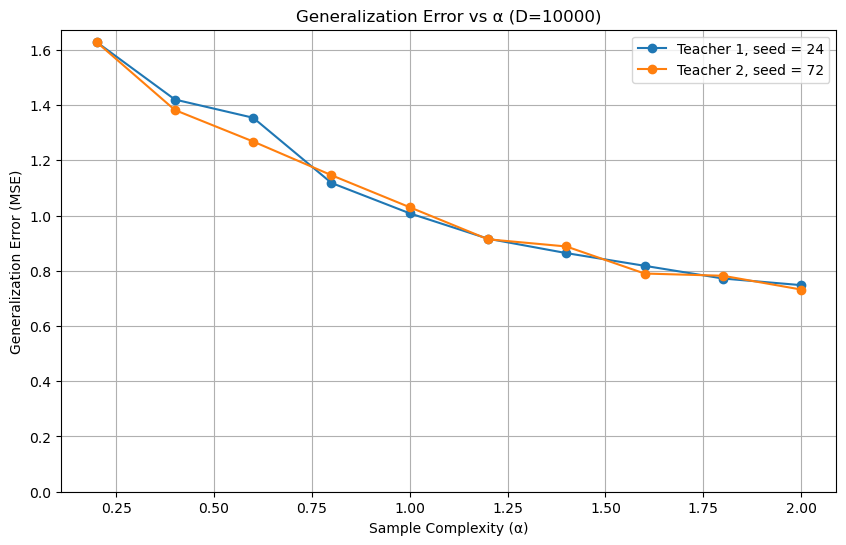

Plot saved as ./figures/generalization_error_D10000_combined.png


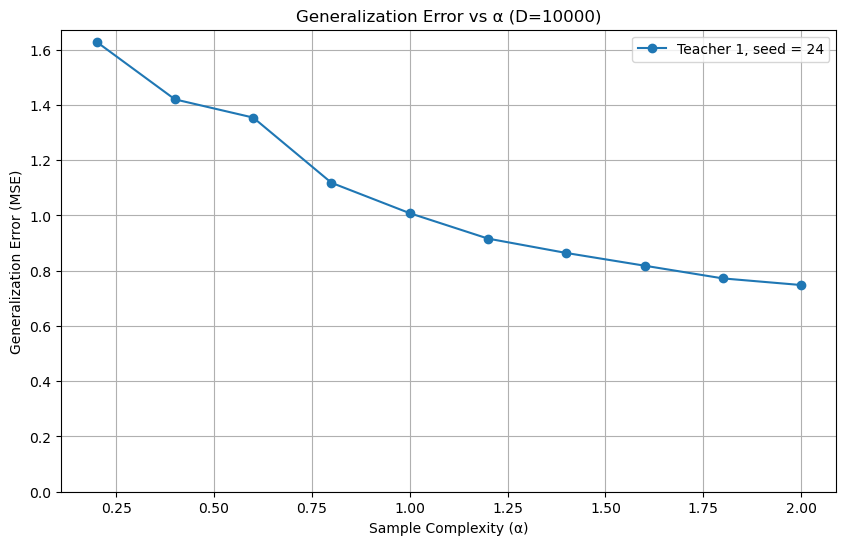

Plot saved as ./figures/generalization_error_D10000_teacher 1.png


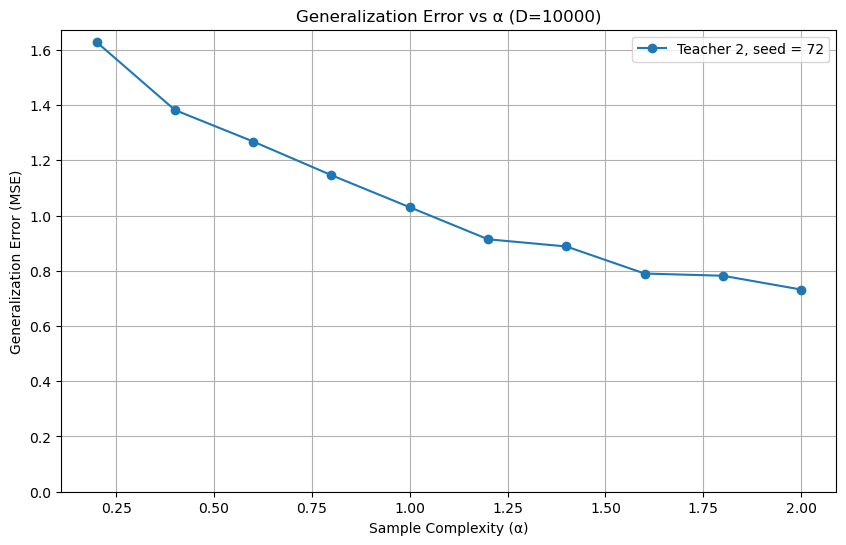

Plot saved as ./figures/generalization_error_D10000_teacher 2.png


In [7]:
print_file_info('./X_data.dat')
print_file_info('./y_data.dat')
alpha_min,alpha_max,alpha_step = 0.2,2,0.2
alphas, errors1 = optimized_training(D=D, teacher_seed=teacher_seed1,alpha_max=alpha_max,alpha_min=alpha_min,alpha_step=alpha_step,batch_size=int(5e3))

if(two_teachers):
    generate_data(D=D, teacher_seed=teacher_seed2)
    _, errors2 = optimized_training(D=D, teacher_seed=teacher_seed2,alpha_max=alpha_max,alpha_min=alpha_min,alpha_step=alpha_step,batch_size=int(5e3))

    plot_results(alphas, [errors1, errors2], [f'Teacher 1, seed = {teacher_seed1}', f'Teacher 2, seed = {teacher_seed2}'], D=D, name='combined')
    plot_results(alphas, [errors1], [f'Teacher 1, seed = {teacher_seed1}'], D=D, name='teacher 1')
    plot_results(alphas, [errors2], [f'Teacher 2, seed = {teacher_seed2}'], D=D, name='teacher 2')
else:
    plot_results(alphas, [errors1], [f'seed = {teacher_seed1}'], D=D, name='plot')

#os.remove('X_data.dat')
#os.remove('y_data.dat')
